In [1]:
from xbbg import blp
import pdblp
import workdays
import datetime
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from scipy import stats
pd.set_option('display.max_columns', 70)

In [2]:
L = ["ES","NQ"]
T = [i + "1 Index" for i in L]
F = ["open","last","high","low","volume"]
F1 = ["px_" + f for f in F ]
# d_from = workdays.workday(datetime.datetime.today(), days=-500).strftime("%Y%m%d")
d_from = "20060101"
d_to = workdays.workday(datetime.datetime.today(), days=-1).strftime("%Y%m%d")
df = blp.bdh(T, F1, d_from, d_to, Calendar="5D", Fill="P").reset_index()
df = df[[df.columns[0][0]]+T]
df.columns = ["Date"] + [l + "_" + f for l in L for f in F]
df['Date'] = pd.to_datetime(df['Date'])
for l in L: 
    df[ l + "_" +"RetD"] = (df[ l + "_open"].pct_change()).tolist()[1:] + [0]
    df[l + "_RetD_Dir"] = np.sign(df[ l + "_RetD"])
    df.loc[df[l + "_RetD_Dir"]==0,l + "_RetD_Dir"] = 1
df.head()

,Date,ES_open,ES_last,ES_high,ES_low,ES_volume,NQ_open,NQ_last,NQ_high,NQ_low,NQ_volume,ES_RetD,ES_RetD_Dir,NQ_RetD,NQ_RetD_Dir
0,2006-01-02,1225.53,1220.18,1226.75,1216.78,465731.0,1919.61,1909.25,1921.91,1903.50,132354.0,-0.003966,-1.0,-0.005996,-1.0
1,2006-01-03,1220.67,1239.63,1242.31,1217.02,1149131.0,1908.10,1948.38,1957.58,1894.29,372421.0,0.015336,1.0,0.021713,1.0
2,2006-01-04,1239.39,1245.22,1246.92,1235.74,902220.0,1949.53,1971.39,1971.97,1941.47,302316.0,0.004704,1.0,0.011213,1.0
3,2006-01-05,1245.22,1245.95,1247.90,1240.60,761183.0,1971.39,1982.90,1985.78,1965.64,245292.0,0.000586,1.0,0.005549,1.0
4,2006-01-06,1245.95,1256.16,1257.38,1244.98,899355.0,1982.33,2011.67,2013.98,1980.03,350719.0,0.007809,1.0,0.014513,1.0


In [3]:
def HR(p, h): 
    v = 0.5 ** ( (np.arange(p,0,-1)-1)/h)
    v = v/sum(v)

    for l in L:
        tmp_HR = np.zeros(len(df))
        tmp_DR = df[l+"_RetD"].values
        
        for i in range(r_from-1,len(df)):
            tmp = 1
            for j in range(p):
                tmp *= (1+tmp_DR[i-p+1+j]) ** v[j]
            tmp_HR[i] = tmp**260 - 1
            
        df[l + "_HR"+str(h)] = tmp_HR
        
r_from = df.query('Date == "2007-03-30"').index[0]
H = [60]
for h in H:
    HR(260,h)       

In [4]:
def RV(p, h):
    v = 0.5 ** ((np.arange(p, 0, -1) - 1) / h)
    v /= v.sum()
    
    for l in L:
        tmp = df[l + "_volume"].values
        for i in range(r_from, len(df)):
            subset = tmp[i - p + 1: i + 1]
            mean_val = subset @ v
            variance = subset**2 @ v - mean_val**2
            df.at[i, l + "_volume_Mean" + str(h)] = mean_val
            df.at[i, l + "_volume_SD" + str(h)] = np.sqrt(variance)
            df.at[i, l + "_volume_CDF" + str(h)] = stats.norm.cdf(tmp[i], mean_val, np.sqrt(variance))
H = [20,60,120]
for h in H:
    RV(260,h)

In [5]:
def DT(l,Model,F,y,d,ratio=0.9,random=42): #Decision Tree
# l: Symbol
# Model: 0=Regression, 1=Classifier
# F: Field
# y
# d: Depth
# ratio: for training

    test = df.loc[r_from:len(df)-2,[l + "_" + f for f in F ]].copy()
    tmp = l + "_" + y
    
    train_size = int(ratio * len(test))
    train_data = test[:train_size]
    test_data = test[train_size:]
    X_train = train_data.drop(columns=[tmp])
    y_train = train_data[tmp]
    X_test = test_data.drop(columns=[tmp])
    y_test = test_data[tmp]

    #Train
    if Model ==0:
        tree_model = DecisionTreeRegressor(max_depth=d, random_state=random)
        msg = "DecisionTreeRegressor"
    else:
        tree_model = DecisionTreeClassifier(max_depth=d, random_state=random)
        msg = "DecisionTreeClassifier"

    tree_model.fit(X_train, y_train)

    #Predict
    y_pred_tree_train = tree_model.predict(X_train)
    y_pred_tree_test = tree_model.predict(X_test)

    #Evaluation
    error_train = mean_absolute_error(y_train, y_pred_tree_train)
    error_test = mean_absolute_error(y_test, y_pred_tree_test)

    print(l,"/",msg)
    print("Absolute_Error_Train:",round(error_train,3))
    print("Absolute_Error_Test:", round(error_test,3))

    #Plot
    plt.figure(figsize=(20, 10))
    plot_tree(tree_model, feature_names=X_train.columns.tolist(), filled=True, rounded=True, fontsize=10)
    plt.show()

ES / DecisionTreeRegressor
Absolute_Error_Train: 0.92
Absolute_Error_Test: 0.975


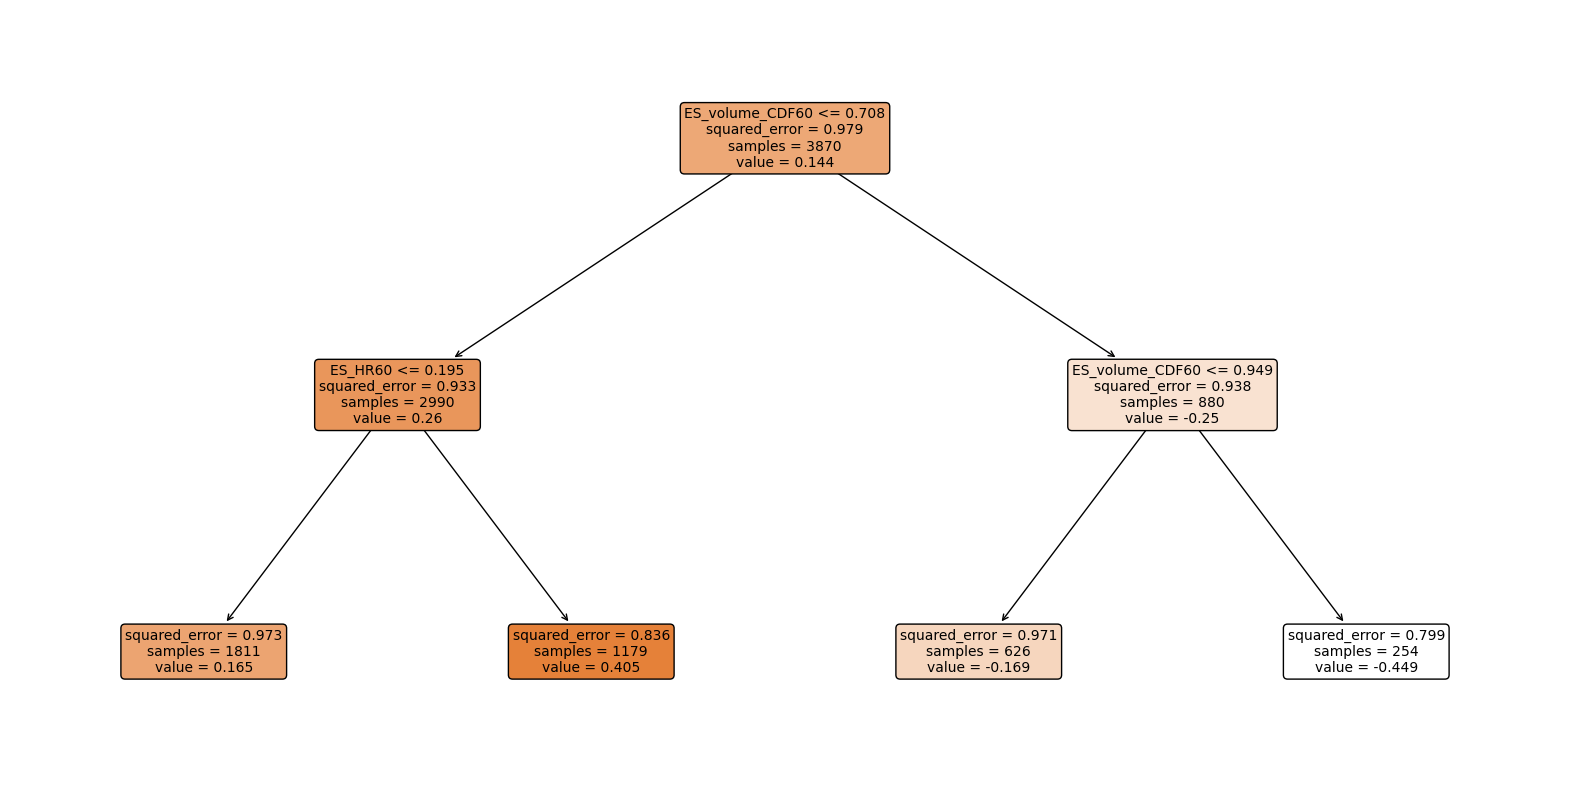

In [6]:
DT("ES",0,["HR60","volume_CDF60","RetD_Dir"],"RetD_Dir",2)

ES / DecisionTreeClassifier
Absolute_Error_Train: 0.743
Absolute_Error_Test: 0.898


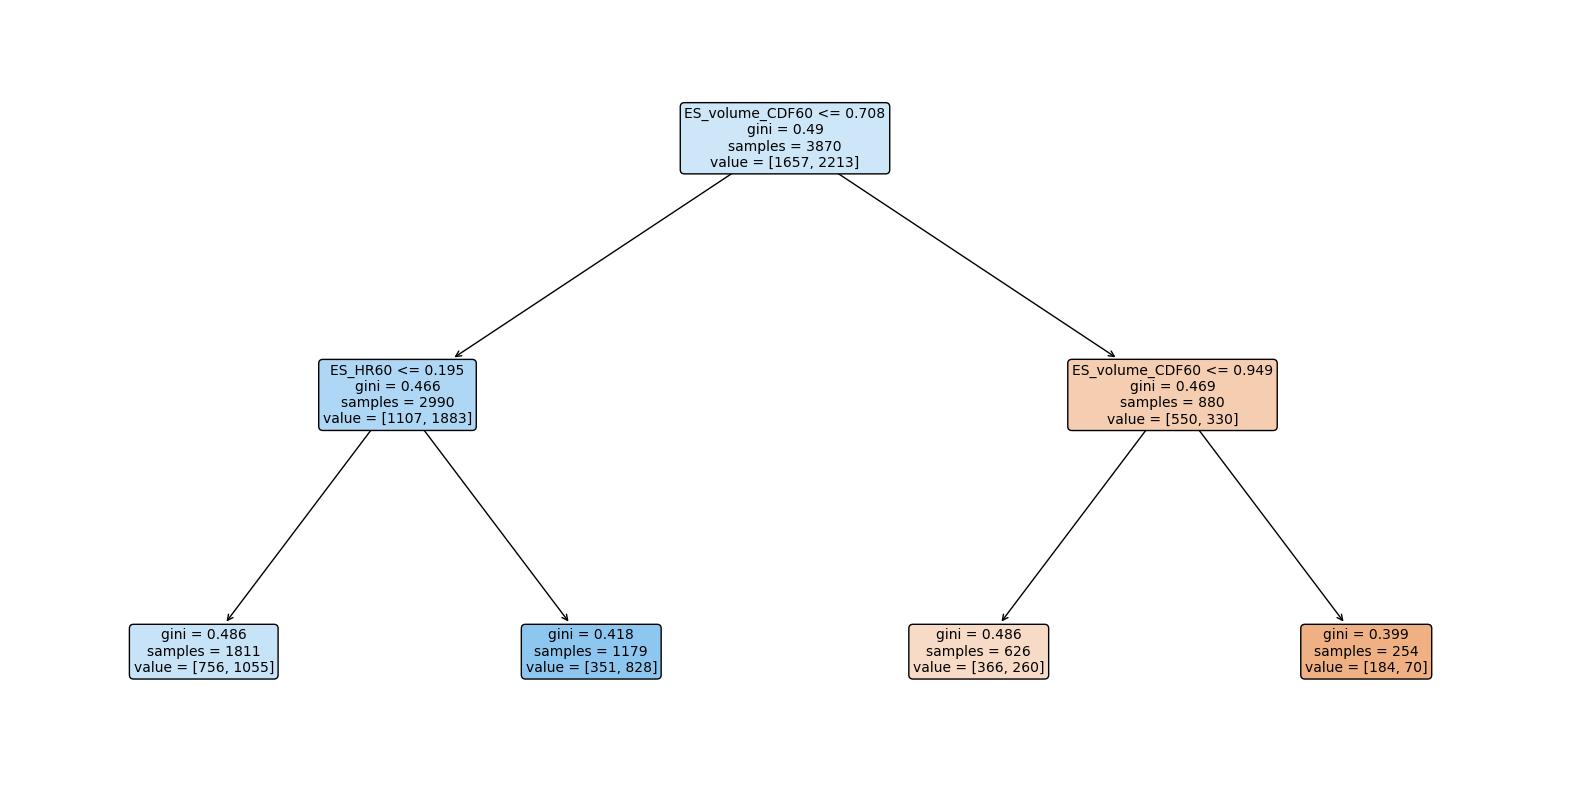

In [15]:
DT("ES",1,["HR60","volume_CDF60","RetD_Dir"],"RetD_Dir",2)

ES / DecisionTreeRegressor
Absolute_Error_Train: 0.008
Absolute_Error_Test: 0.009


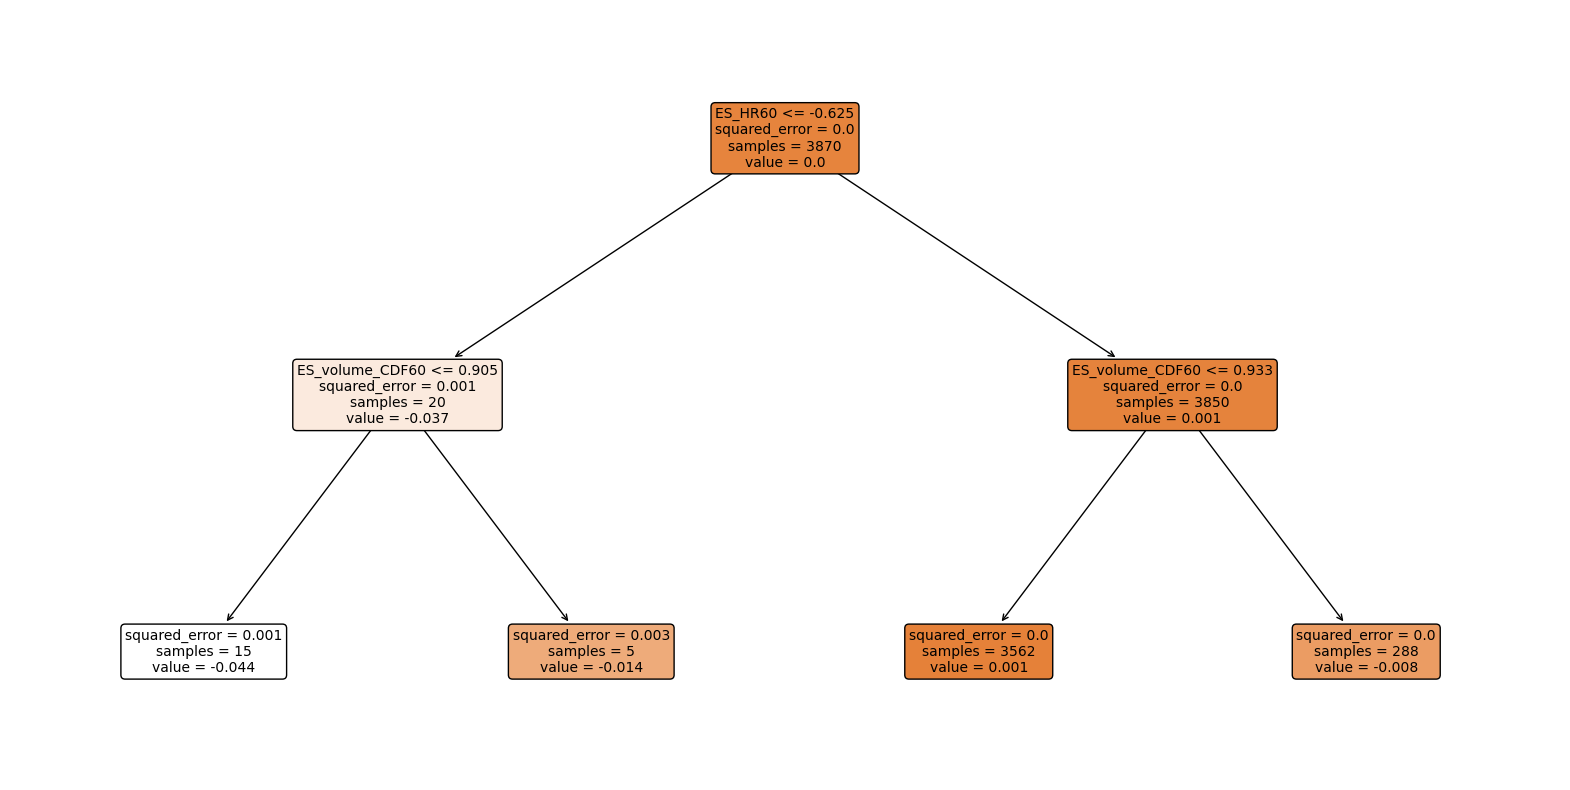

In [8]:
DT("ES",0,["HR60","volume_CDF60","RetD"],"RetD",2)

In [14]:
test

,ES_open,ES_last,ES_high,ES_low,ES_volume
324,1334.39,1333.93,1341.85,1321.58,1399338.0
325,1334.39,1335.79,1338.35,1328.80,904543.0
326,1336.02,1348.84,1351.87,1335.79,1008408.0
327,1348.61,1350.01,1351.40,1346.04,753211.0
328,1349.54,1353.97,1355.83,1347.91,520584.0
...,...,...,...,...,...
4619,4556.50,4498.00,4566.00,4494.00,1825966.0
4620,4499.50,4501.50,4514.50,4487.00,1155158.0
4621,4503.25,4490.00,4509.50,4462.25,1422950.0
4622,4491.25,4447.00,4508.00,4443.25,1482206.0


In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

l = "ES"
y = "RetD_Dir"
ratio = 0.9
F = ["HR60","volume_CDF60","RetD_Dir"]
test = df.loc[r_from:len(df)-2,[l + "_" + f for f in F ]].copy()
tmp = l + "_" + y

train_size = int(ratio * len(test))
train_data = test[:train_size]
test_data = test[train_size:]
X_train = train_data.drop(columns=[tmp])
y_train = train_data[tmp]
X_test = test_data.drop(columns=[tmp])
y_test = test_data[tmp]
    
# Create and train the random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict using the test data
y_pred = rf.predict(X_test)

# Calculate and display the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.5279
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.53      0.46      0.49       213
         1.0       0.53      0.59      0.56       217

    accuracy                           0.53       430
   macro avg       0.53      0.53      0.53       430
weighted avg       0.53      0.53      0.53       430

Confusion Matrix:
[[ 99 114]
 [ 89 128]]


#### 1.Accuracy (正解率)

#### 2.Classification Report (分類レポート)
Precision: 予測されたクラスの中で、実際にそのクラスであったインスタンスの割合です。<br>
-1.0 のPrecisionは0.53: -1.0と予測されたもののうち、53%が実際に-1.0でした。<br>
1.0 のPrecisionは0.53: 1.0と予測されたもののうち、53%が実際に1.0でした。<br>
Recall (or Sensitivity): 実際のクラスの中で、正確に分類されたインスタンスの割合です。<br>
-1.0 のRecallは0.46: 実際の-1.0のうち、46%が-1.0として正確に分類されました。<br>
1.0 のRecallは0.59: 実際の1.0のうち、59%が1.0として正確に分類されました。<br>
F1-score: PrecisionとRecallの調和平均です。PrecisionとRecallのバランスを示す指標で、1に近いほど良いとされます。<br>


#### 3.Confusion Matrix (混同行列)
[[ 99 114] <br>
 [ 89 128]]<br>
混同行列は、実際のクラスと予測されたクラスの組み合わせごとのインスタンス数を示しています。<br>
左上の99: 実際に-1.0で、-1.0と正確に分類された数。<br>
右上の114: 実際に-1.0だが、1.0と誤って分類された数。<br>
左下の89: 実際に1.0だが、-1.0と誤って分類された数。<br>
右下の128: 実際に1.0で、1.0と正確に分類された数。<br>
総じて、このモデルの正解率は約53%となっており、完璧ではりませんが、ランダムな予測よりはいくぶん良い結果を示しています。精度の向上のためには、特徴量のエンジニアリング、モデルのハイパーパラメータの調整、または他のアルゴリズムの試用などが考えられます。





